<a href="https://www.kaggle.com/code/leotom/btp-phase-1?scriptVersionId=149739783" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bananas-dataset-2/val/xamthomonas/20210219_150904.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210219_121427.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210220_111539.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210219_150309.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210219_112245.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210220_105629.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210219_154738.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210219_151919.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210219_154312.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210220_112616.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210219_145717.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210219_144846.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210220_105909.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/20210220_105939.jpg
/kaggle/input/bananas-dataset-2/val/xamthomonas/

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

from pathlib import Path

from math import floor

import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
import pickle
import os
from tensorflow.keras.utils import img_to_array
from keras.applications.resnet import ResNet50
from keras.layers import GlobalMaxPooling2D, Dense, GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

default_image_size = tuple((229, 229))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import ResNet50

import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [5]:
# resizing all the images to same dimensions
# for uniformity
IMAGE_SIZE = (224, 224,3)

train_path = '/kaggle/input/bananas-dataset-2/train'
valid_path = '/kaggle/input/bananas-dataset-2/val'

In [6]:
inception_pre = InceptionV3(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
inception_new = InceptionV3(input_shape=IMAGE_SIZE, include_top=False)

resnet_pre = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
resnet_new = ResNet50(input_shape=IMAGE_SIZE, include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [7]:
folders = glob(train_path+"/*")
print(len(folders))

3


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1031 images belonging to 3 classes.


In [10]:
testing_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 258 images belonging to 3 classes.


## InceptionV3 Pre

In [11]:
inception_pre_flattened = Flatten()(inception_pre.output)
prediction = Dense(len(folders), activation='softmax')(inception_pre_flattened)
model = Model(inputs=inception_pre.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
# batch_size = 16
# epochs = 40
# INIT_LR = 1e-3
# my_callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
# ]

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.9)

# opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

In [13]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt)

In [14]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [15]:
r = model.fit(
  training_set,
  validation_data=testing_set,
  epochs=20,
)

Epoch 1/20
33/33 [==============================] - 33s 543ms/step - loss: 2.3059 - accuracy: 0.5946 - val_loss: 1.7664 - val_accuracy: 0.6318
Epoch 2/20
33/33 [==============================] - 12s 354ms/step - loss: 1.1073 - accuracy: 0.6314 - val_loss: 0.8550 - val_accuracy: 0.6589
Epoch 3/20
33/33 [==============================] - 12s 358ms/step - loss: 0.8658 - accuracy: 0.6964 - val_loss: 0.7738 - val_accuracy: 0.7093
Epoch 4/20
33/33 [==============================] - 12s 361ms/step - loss: 0.6297 - accuracy: 0.7895 - val_loss: 1.6108 - val_accuracy: 0.7209
Epoch 5/20
33/33 [==============================] - 12s 355ms/step - loss: 0.5330 - accuracy: 0.8118 - val_loss: 1.5495 - val_accuracy: 0.7946
Epoch 6/20
33/33 [==============================] - 12s 362ms/step - loss: 0.4316 - accuracy: 0.8390 - val_loss: 0.6882 - val_accuracy: 0.8295
Epoch 7/20
33/33 [==============================] - 12s 361ms/step - loss: 0.3531 - accuracy: 0.8661 - val_loss: 0.6354 - val_accuracy: 0.8372

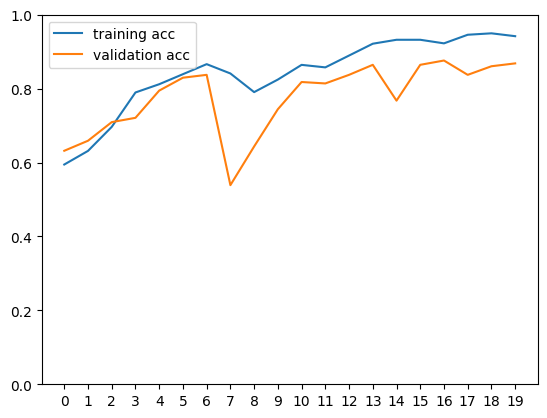

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(r.history['accuracy'], label='training acc')
plt.plot(r.history['val_accuracy'], label='validation acc')
plt.xticks([i for i in range(20)])
plt.ylim([0, 1])
plt.legend()
plt.show()
plt.savefig('Accuracy_Plot')

## Resnet50 Pre

In [17]:
resnet_pre_flattened = Flatten()(resnet_pre.output)
prediction = Dense(len(folders), activation='softmax')(resnet_pre_flattened)
model = Model(inputs=resnet_pre.input, outputs=prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [18]:
# batch_size = 16
# epochs = 40
# INIT_LR = 1e-3
# my_callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
# ]

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=10000,
#     decay_rate=0.9)

# opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

In [19]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt)

In [20]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [21]:
r = model.fit(
  training_set,
  validation_data=testing_set,
  epochs=20,
  batch_size = 16,
  steps_per_epoch=len(training_set),
  validation_steps=len(testing_set),
  shuffle = True
)

Epoch 1/20
33/33 [==============================] - 21s 429ms/step - loss: 2.4689 - accuracy: 0.6877 - val_loss: 2.2919 - val_accuracy: 0.6318
Epoch 2/20
33/33 [==============================] - 12s 364ms/step - loss: 4.7322 - accuracy: 0.6004 - val_loss: 596.0986 - val_accuracy: 0.6318
Epoch 3/20
33/33 [==============================] - 12s 355ms/step - loss: 1.7124 - accuracy: 0.6411 - val_loss: 379.2560 - val_accuracy: 0.6318
Epoch 4/20
33/33 [==============================] - 12s 367ms/step - loss: 1.0117 - accuracy: 0.6741 - val_loss: 1.0552 - val_accuracy: 0.6318
Epoch 5/20
33/33 [==============================] - 12s 361ms/step - loss: 0.7762 - accuracy: 0.6566 - val_loss: 1.0254 - val_accuracy: 0.6318
Epoch 6/20
33/33 [==============================] - 12s 369ms/step - loss: 1.0144 - accuracy: 0.6984 - val_loss: 1.0449 - val_accuracy: 0.6318
Epoch 7/20
33/33 [==============================] - 12s 362ms/step - loss: 0.8964 - accuracy: 0.6945 - val_loss: 1.2249 - val_accuracy: 0.

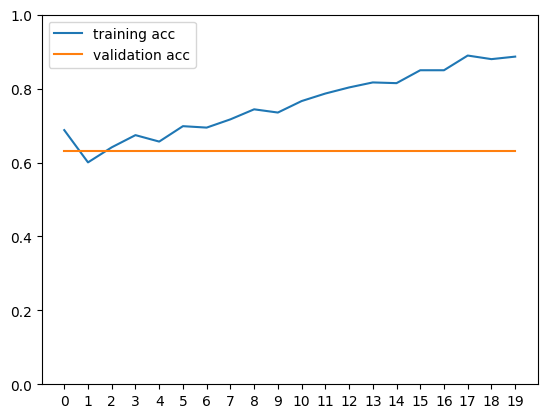

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(r.history['accuracy'], label='training acc')
plt.plot(r.history['val_accuracy'], label='validation acc')
plt.xticks([i for i in range(20)])
plt.ylim([0, 1])
plt.legend()
plt.show()
plt.savefig('Accuracy_Plot')